# 3 state discrimination

## Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential,load_model
from keras import layers,Input
from keras.losses import binary_crossentropy,categorical_crossentropy
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.constraints import Constraint
from sklearn.metrics import confusion_matrix
import seaborn as sns


2024-05-06 11:12:21.199052: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 11:12:21.802206: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 11:12:21.804543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 11:12:24.087931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
state0=np.load('../Data/ML/031924/state0.npy')
state1=np.load('../Data/ML/031924/state1.npy')
state2=np.load('../Data/ML/031924/state2.npy')
output0=np.zeros((state0.shape[0]))
output1=np.ones((state1.shape[0]))
output2=np.array((2,)*state2.shape[0])

## LOC

0.17892490587019005
1.520795071679507


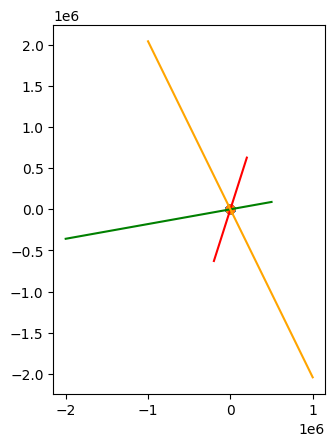

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# # Generate synthetic data
# np.random.seed(42)
# state0 = np.random.normal(loc=[5, -1], scale=[1, 1], size=(10000, 2))
# state1 = np.random.normal(loc=[6, 6], scale=[1, 1], size=(10000, 2))
# state2 = np.random.normal(loc=[12, 1], scale=[1, 1], size=(10000, 2))
data = np.vstack([state0, state1, state2])


plt.scatter(data[:,0],data[:,1])
center = np.array([state0.mean(axis=0), state1.mean(axis=0), state2.mean(axis=0)])
slop=np.array([(center[1][1]-center[0][1])/(center[1][0]-center[0][0]), (center[2][1]-center[1][1])/(center[2][0]-center[1][0]), (center[0][1]-center[2][1])/(center[0][0]-center[2][0])])
intercept = np.array([center[0][1]-(slop[0]*center[0][0]), center[1][1]-(slop[1]*center[1][0]), center[2][1]-(slop[2]*center[2][0])])
dp = np.array([[(center[1][0]+center[0][0])/2,(center[1][1]+center[0][1])/2], [(center[2][0]+center[1][0])/2,(center[2][1]+center[1][1])/2], [(center[0][0]+center[2][0])/2,(center[0][1]+center[2][1])/2]])
# plt.plot([center[0][0],center[1][0]],[center[0][1],center[1][1]],color='red')
plt.scatter(dp[:,0],dp[:,1])
#orthogonal
orthSlop=-1/slop
orthIntercept=np.array([dp[0][1]-(orthSlop[0]*dp[0][0]), dp[1][1]-(orthSlop[1]*dp[1][0]), dp[2][1]-(orthSlop[2]*dp[2][0])])
x=np.array([[-.2e6,.2e6],[-2e6,.5e6],[-1e6,1e6]])
y=np.array([[(x[0][0]*orthSlop[0])+orthIntercept[0],(x[0][1]*orthSlop[0])+orthIntercept[0]], [(x[1][0]*orthSlop[1])+orthIntercept[1],(x[1][1]*orthSlop[1])+orthIntercept[1]], [(x[2][0]*orthSlop[2])+orthIntercept[2],(x[2][1]*orthSlop[2])+orthIntercept[2]]])

plt.plot(x[0],y[0],color='red')
plt.plot(x[1],y[1],color='green')
plt.plot(x[2],y[2],color='orange')

plt.gca().set_aspect('equal', adjustable='box')
print(orthSlop[1])
print(orthIntercept[2])

In [ ]:
## Inference
count0=0
for i in state0:
    vector_i=[i[0]-center[0],i[1]-center[1]]
    proj = np.dot(vector,vector_i)
    if proj>0:
        count0+=1
print(count0/state0.shape[0])
count1=0
for i in state1:
    vector_i=[i[0]-center[0],i[1]-center[1]]
    proj = np.dot(vector,vector_i)
    if proj<0:
        count1+=1
print(count1/state1.shape[0])


## Scaling

In [3]:
x=np.concatenate((state0,state1,state2),axis=0)
print(x.shape)
y=np.hstack((output0,output1,output2))
print(y.shape)

encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(y.reshape(-1, 1))
y1 = one_hot_encoded.toarray()
print(y1.shape)


(145295, 2)
(145295,)
(145295, 3)


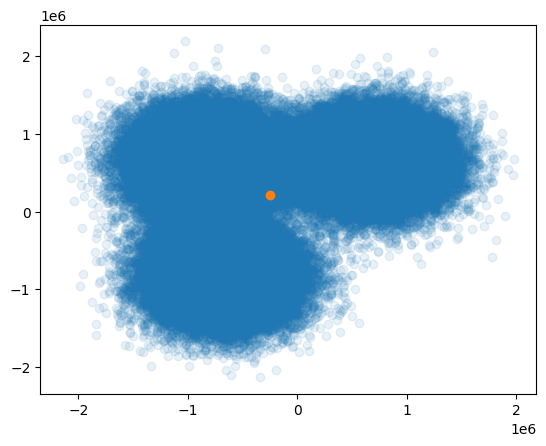

In [4]:
mean=np.mean(x,axis=0)
plt.scatter(x[:,0],x[:,1],alpha=0.1)
plt.scatter(mean[0],mean[1],alpha=1)

In [5]:
x[:,0]+= 0
x[:,1]+= 0
print(x[:,0].max(),x[:,0].min())
print(x[:,1].max(),x[:,1].min())

1975877.0 -2143526.0
2192145.0 -2134893.0


0.7355427742004395 0.24447166919708252
0.7613239288330078 0.24550080299377441


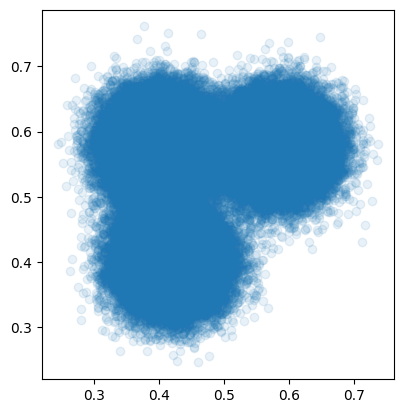

In [6]:
x[:,0]=(x[:,0]+(2**22)-1)/(2**23)
x[:,1]=(x[:,1]+(2**22)-1)/(2**23)
print(x[:,0].max(),x[:,0].min())
print(x[:,1].max(),x[:,1].min())
plt.gca().set_aspect('equal')
plt.scatter(x[:,0],x[:,1],alpha=0.1)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y1, test_size=0.40, random_state=45)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(87177, 2)
(58118, 2)
(87177, 3)


## Cleaning

In [8]:

def md(cluster_mean, cluster_covariance, point):
    # Calculate the difference between the point and the mean of the cluster
    diff = point - cluster_mean
    
    # Calculate the inverse of the covariance matrix
    inv_cov_matrix = np.linalg.inv(cluster_covariance)
    
    # Calculate the Mahalanobis distance
    mahalanobis_dist = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
    
    return mahalanobis_dist


In [9]:
µ0,µ1,µ2=np.mean(x_train[(y_train==[1,0,0]).all(axis=1),:], axis=0),np.mean(x_train[(y_train==[0,1,0]).all(axis=1),:], axis=0),np.mean(x_train[(y_train==[0,0,1]).all(axis=1),:], axis=0)
cov0,cov1,cov2=np.cov(x_train[(y_train==[1,0,0]).all(axis=1)],rowvar=False),np.cov(x_train[(y_train==[0,1,0]).all(axis=1)],rowvar=False),np.cov(x_train[(y_train==[0,0,1]).all(axis=1)],rowvar=False)

In [10]:
x_train_pro,y_train_pro=[],[]
for i in range(x_train.shape[0]):
    if (y_train[i]==[1,0,0]).all():
        dist_og,dist1,dist2=md(µ0,cov0,x_train[i]),md(µ1,cov1,x_train[i]),md(µ2,cov2,x_train[i])
        if min(dist2,dist1,dist_og)== dist_og:
            x_train_pro.append(x_train[i])
            y_train_pro.append(y_train[i])
    elif (y_train[i]==[0,1,0]).all():
        dist0,dist_og,dist2=md(µ0,cov0,x_train[i]),md(µ1,cov1,x_train[i]),md(µ2,cov2,x_train[i])
        if min(dist2,dist0,dist_og)== dist_og:
            x_train_pro.append(x_train[i])
            y_train_pro.append(y_train[i])
    else:   
        dist0,dist1,dist_og=md(µ0,cov0,x_train[i]),md(µ1,cov1,x_train[i]),md(µ2,cov2,x_train[i])
        if min(dist1,dist0,dist_og)== dist_og:
            x_train_pro.append(x_train[i])
            y_train_pro.append(y_train[i])
x_train_pro=np.array(x_train_pro)
y_train_pro=np.array(y_train_pro)

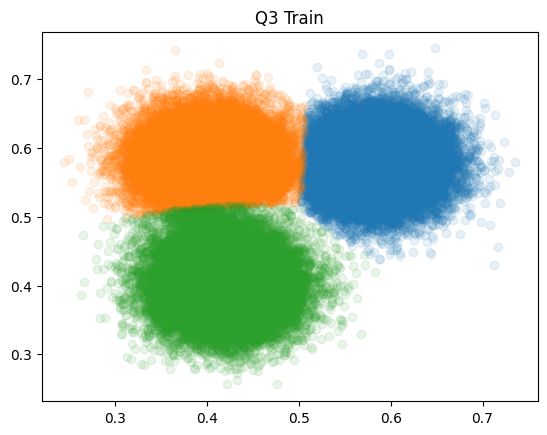

In [11]:
plt.scatter(x_train_pro[(y_train_pro==[1,0,0]).all(axis=1),0],x_train_pro[(y_train_pro==[1,0,0]).all(axis=1),1], alpha=0.1, label = '|0>')
plt.scatter(x_train_pro[(y_train_pro==[0,1,0]).all(axis=1),0],x_train_pro[(y_train_pro==[0,1,0]).all(axis=1),1], alpha=0.1, label = '|1>')
plt.scatter(x_train_pro[(y_train_pro==[0,0,1]).all(axis=1),0],x_train_pro[(y_train_pro==[0,0,1]).all(axis=1),1], alpha=0.1, label = '|2>')
plt.title('Q3 Train')
# plt.legend()
plt.show()


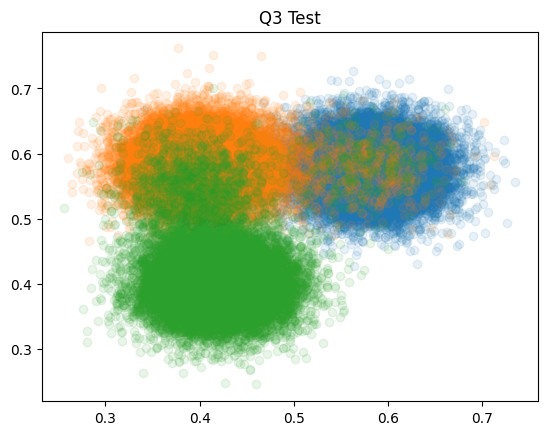

In [12]:
plt.scatter(x_test[(y_test==[1,0,0]).all(axis=1),0],x_test[(y_test==[1,0,0]).all(axis=1),1], alpha=0.1, label = '|0>')
plt.scatter(x_test[(y_test==[0,1,0]).all(axis=1),0],x_test[(y_test==[0,1,0]).all(axis=1),1], alpha=0.1, label = '|1>')
plt.scatter(x_test[(y_test==[0,0,1]).all(axis=1),0],x_test[(y_test==[0,0,1]).all(axis=1),1], alpha=0.1, label = '|2>')
plt.title('Q3 Test')
# plt.legend()
plt.show()

## Lines

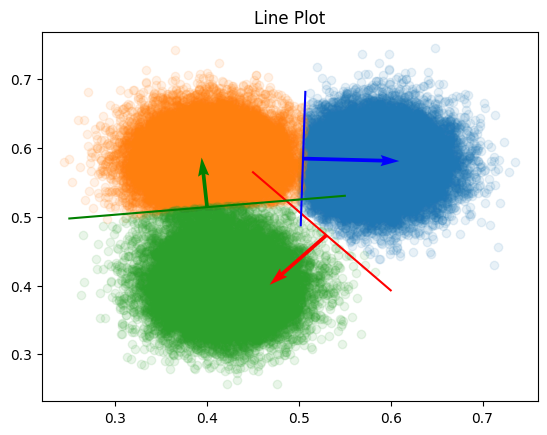

In [93]:
state0=x_train_pro[(y_train_pro==[1,0,0]).all(axis=1),:]
state1=x_train_pro[(y_train_pro==[0,1,0]).all(axis=1),:]
state2=x_train_pro[(y_train_pro==[0,0,1]).all(axis=1),:]

plt.scatter(state0[:,0],state0[:,1],alpha=0.1)
plt.scatter(state1[:,0],state1[:,1],alpha=0.1)
plt.scatter(state2[:,0],state2[:,1],alpha=0.1)


m = -1.145  # Example slope
b = 1.08  # Example intercept
x = np.linspace(0.45, .6, 100)  # Generate 100 points between -10 and 10
y1 = m * x + b
n1 = np.array([-1.145, -1])
plt.plot(x, y1, color='red')
plt.title('Line Plot')
x_pointr = 0.53
y_pointr = m * x_pointr + b
plt.quiver(x_pointr, y_pointr, n1[0], n1[1], color='red', scale=10)

m = 38.80  # Example slope
b = -18.99  # Example intercept
x = np.linspace(0.502, .507, 100)  # Generate 100 points between -10 and 10
y2 = m * x + b
n2 = np.array([38.80, -1])
plt.plot(x, y2, color='blue')
plt.title('Line Plot')
x_pointb = .5045
y_pointb = m * x_pointb + b
plt.quiver(x_pointb, y_pointb, n2[0], n2[1], color='blue', scale=200)

m = 0.11  # Example slope
b = 0.47 # Example intercept
x = np.linspace(.25, .55, 100)  # Generate 100 points between -10 and 10
y3 = m * x + b
n3 = np.array([-0.11, 1])
plt.plot(x, y3, color='green')
plt.title('Line Plot')
x_pointg = .4
y_pointg = m * x_pointg + b
plt.quiver(x_pointg, y_pointg, n3[0], n3[1], color='green', scale=10)


In [94]:
pred0,state0=0,0
pred1,state1=0,0
pred2,state2=0,0
for k,i in enumerate(x_train_pro):
    if (y_train_pro[k,]==[1,0,0]).all():
        if np.dot(np.array([i[0]-x_pointb, i[1]-y_pointb]).T, n2) > 0 and np.dot(np.array([i[0]-x_pointr, i[1]-y_pointr]).T, n1) < 0:
            pred0+=1
        state0+=1
    elif (y_train_pro[k,]==[0,1,0]).all():
        if np.dot(np.array([i[0]-x_pointg, i[1]-y_pointg]).T, n3) > 0 and np.dot(np.array([i[0]-x_pointb, i[1]-y_pointb]).T, n2) < 0:
            pred1+=1
        state1+=1
    elif (y_train_pro[k,]==[0,0,1]).all():
        if np.dot(np.array([i[0]-x_pointr, i[1]-y_pointr]).T, n1) > 0 and np.dot(np.array([i[0]-x_pointg, i[1]-y_pointg]).T, n3) < 0:
            pred2+=1
        state2+=1
print(pred0/state0)
print(pred1/state1)
print(pred2/state2)


0.9994092504430622
0.997876778663488
0.9996630980010481


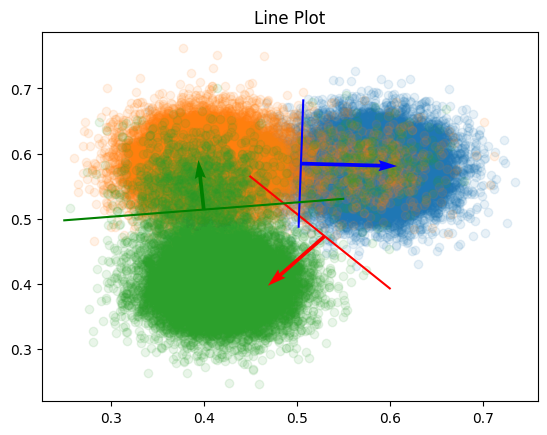

In [96]:
state0=x_test[(y_test==[1,0,0]).all(axis=1),:]
state1=x_test[(y_test==[0,1,0]).all(axis=1),:]
state2=x_test[(y_test==[0,0,1]).all(axis=1),:]

plt.scatter(state0[:,0],state0[:,1],alpha=0.1)
plt.scatter(state1[:,0],state1[:,1],alpha=0.1)
plt.scatter(state2[:,0],state2[:,1],alpha=0.1)

m = -1.145  # Example slope
b = 1.08  # Example intercept
x = np.linspace(0.45, .6, 100)  # Generate 100 points between -10 and 10
y1 = m * x + b
n1 = np.array([-1.145, -1])
plt.plot(x, y1, color='red')
plt.title('Line Plot')
x_pointr = 0.53
y_pointr = m * x_pointr + b
plt.quiver(x_pointr, y_pointr, n1[0], n1[1], color='red', scale=10)

m = 38.80  # Example slope
b = -18.99  # Example intercept
x = np.linspace(0.502, .507, 100)  # Generate 100 points between -10 and 10
y2 = m * x + b
n2 = np.array([38.80, -1])
plt.plot(x, y2, color='blue')
plt.title('Line Plot')
x_pointb = .5045
y_pointb = m * x_pointb + b
plt.quiver(x_pointb, y_pointb, n2[0], n2[1], color='blue', scale=200)

m = 0.11  # Example slope
b = 0.47 # Example intercept
x = np.linspace(.25, .55, 100)  # Generate 100 points between -10 and 10
y3 = m * x + b
n3 = np.array([-0.11, 1])
plt.plot(x, y3, color='green')
plt.title('Line Plot')
x_pointg = .4
y_pointg = m * x_pointg + b
plt.quiver(x_pointg, y_pointg, n3[0], n3[1], color='green', scale=10)

In [97]:
pred0,state0=0,0
pred1,state1=0,0
pred2,state2=0,0
for k,i in enumerate(x_test):
    if (y_test[k,]==[1,0,0]).all():
        if np.dot(np.array([i[0]-x_pointb, i[1]-y_pointb]).T, n2) > 0 and np.dot(np.array([i[0]-x_pointr, i[1]-y_pointr]).T, n1) < 0:
            pred0+=1
        state0+=1
    elif (y_test[k,]==[0,1,0]).all():
        if np.dot(np.array([i[0]-x_pointg, i[1]-y_pointg]).T, n3) > 0 and np.dot(np.array([i[0]-x_pointb, i[1]-y_pointb]).T, n2) < 0:
            pred1+=1
        state1+=1
    elif (y_test[k,]==[0,0,1]).all():
        if np.dot(np.array([i[0]-x_pointr, i[1]-y_pointr]).T, n1) > 0 and np.dot(np.array([i[0]-x_pointg, i[1]-y_pointg]).T, n3) < 0:
            pred2+=1
        state2+=1
print(pred0/state0)
print(pred1/state1)
print(pred2/state2)

0.9733203605079885
0.9302325581395349
0.9250809230447948


## Logistic Regressor

In [99]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x_train, y_train)
print(classifier.score(x_test,y_test))
pred = classifier.predict(x_test)

0.9570323689487253


In [100]:
# Extract coefficients and intercepts
coefficients = classifier.coef_
intercepts = classifier.intercept_

# Calculate slopes and y-intercepts for decision boundaries in 2D
slopes = -coefficients[:, 0] / coefficients[:, 1]
y_intercepts = -intercepts / coefficients[:, 1]

# Print the number of decision boundaries, slopes, and intercepts
num_boundaries = len(coefficients)
print("Number of decision boundaries:", num_boundaries)
print("Slopes of each boundary:", slopes)
print("Y-intercepts of each boundary:", y_intercepts)

Number of decision boundaries: 3
Slopes of each boundary: [-1.9398972   1.12074241 -0.49737686]
Y-intercepts of each boundary: [ 1.50823569 -0.05982049  0.76918986]


Class 0:
Total in test: 19701
Correct predictions: 19529
Precision: 0.9912694787066646
*********
Class 1:
Total in test: 19850
Correct predictions: 18469
Precision: 0.9304282115869018
*********
Class 2:
Total in test: 19796
Correct predictions: 18799
Precision: 0.9496362901596282
*********


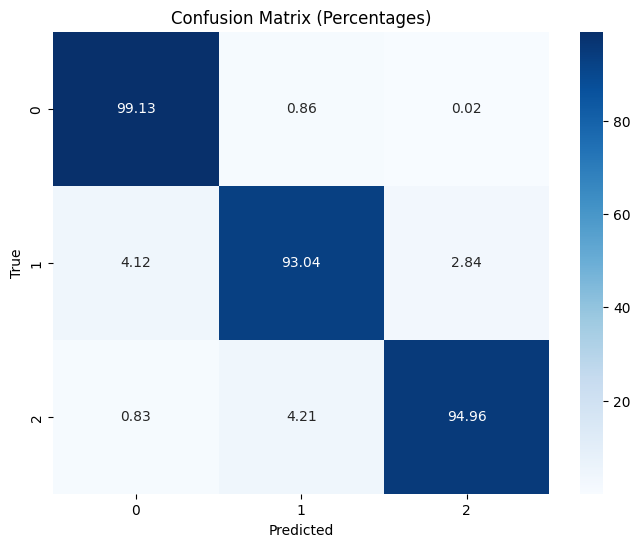

In [101]:
y_pred = classifier.predict(x_test)

# Calculate the counts and ratios for each class
for class_label in range(3):  # assuming three classes: 0, 1, 2
    count = (y_test == class_label).sum()
    count1 = ((y_test == class_label) & (y_pred == class_label)).sum()
    print(f"Class {class_label}:")
    print("Total in test:", count)
    print("Correct predictions:", count1)
    print("Precision:", count1 / count if count != 0 else 0)
    print('*********')

# Compute and plot the normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize and convert to percentage

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()


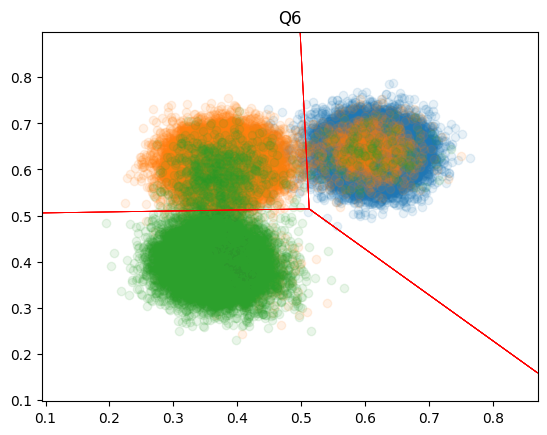

In [102]:
x_min, x_max = x[:, 0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min,x_max, 20000), np.linspace(y_min, y_max, 20000))
x_in = np.c_[xx.ravel(), yy.ravel()]
y_pred = classifier.predict(x_in)
y_pred = np.round(y_pred).reshape(xx.shape)
plt.contour(xx, yy, y_pred, colors='red', linewidths=0.6)
plt.scatter(x_test[y_test==0,0],x_test[y_test==0,1],alpha=0.1,label='|0>')
plt.scatter(x_test[y_test==1,0],x_test[y_test==1,1],alpha=0.1,label='|1>')
plt.scatter(x_test[y_test==2,0],x_test[y_test==2,1],alpha=0.1,label='|2>')
plt.title('Q6')
# plt.legend()
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

## SVM

In [10]:
from sklearn.svm import SVC
model=SVC(kernel='linear',decision_function_shape='ovr',probability=True,max_iter=100)
model.fit(x_train,y_train)
print(model.score(x_test,y_test))
pred=model.predict(x_test)

/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.6359060402684564


## NN

In [13]:
class WeightConstraint(Constraint):
    def __init__(self, min_value=-2, max_value=2, precision=6):
        self.min_value = min_value
        self.max_value = max_value
        self.precision = precision

    def __call__(self, w):
        clipped = K.clip(w, self.min_value, self.max_value)
        return K.round(clipped * 10**self.precision) / 10**self.precision

    def get_config(self):
        return {'min_value': self.min_value, 'max_value': self.max_value, 'precision': self.precision}


def arch():
    model=Sequential()
    model.add(Input(shape=(2)))
    model.add(Dense(8,activation='relu', name='HiddenLayer1'))#,kernel_constraint=WeightConstraint()))
    # model.add(Dense(8,activation='relu', name='HiddenLayer2'))#,kernel_constraint=WeightConstraint()))
    model.add(Dense(3,activation='softmax', name='OuputLayer'))#,kernel_constraint=WeightConstraint()))
    return model
arch().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 8)                 24        
                                                                 


2024-05-06 11:14:00.503931: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 OuputLayer (Dense)          (None, 3)                 27        
                                                                 
Total params: 51 (204.00 Byte)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model=arch()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_path="../Model/NN2/tmp/{epoch:02d}-{val_loss:.4f}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [15]:
H=model.fit(x_train,y_train,
          validation_data=(x_test,y_test),
        #   validation_split=0.2,
          epochs=100,batch_size=512,
          callbacks=callbacks_list,
          verbose=1)

Epoch 1/100
137/171 [=======================>......] - ETA: 0s - loss: 1.0793 - accuracy: 0.3785
Epoch 1: val_accuracy improved from -inf to 0.37488, saving model to ../Model/NN2/tmp/01-1.0501-0.3749.h5
171/171 [==============================] - 1s 4ms/step - loss: 1.0745 - accuracy: 0.3824 - val_loss: 1.0501 - val_accuracy: 0.3749
Epoch 2/100
146/171 [========================>.....] - ETA: 0s - loss: 1.0260 - accuracy: 0.5421

/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.37488 to 0.77788, saving model to ../Model/NN2/tmp/02-0.9893-0.7779.h5
171/171 [==============================] - 0s 2ms/step - loss: 1.0215 - accuracy: 0.5704 - val_loss: 0.9893 - val_accuracy: 0.7779
Epoch 3/100
150/171 [=========================>....] - ETA: 0s - loss: 0.9548 - accuracy: 0.8609
Epoch 3: val_accuracy improved from 0.77788 to 0.91256, saving model to ../Model/NN2/tmp/03-0.9069-0.9126.h5
171/171 [==============================] - 0s 2ms/step - loss: 0.9496 - accuracy: 0.8680 - val_loss: 0.9069 - val_accuracy: 0.9126
Epoch 4/100
117/171 [===================>..........] - ETA: 0s - loss: 0.8746 - accuracy: 0.9254
Epoch 4: val_accuracy improved from 0.91256 to 0.93279, saving model to ../Model/NN2/tmp/04-0.8097-0.9328.h5
171/171 [==============================] - 0s 2ms/step - loss: 0.8589 - accuracy: 0.9293 - val_loss: 0.8097 - val_accuracy: 0.9328
Epoch 5/100
122/171 [====================>.........] - ETA: 0s - loss: 0.7733 - accur

In [16]:
count=0
count1=0
# model=load_model('/global/homes/n/nrvora/Projects/Quantum/Model/NN2/tmp/82-0.1852-0.9488.h5')
y_pred=model.predict(x_test)
argmax_indices = np.argmax(y_pred, axis=1)
num_classes = y_pred.shape[1]
y_pred = np.zeros_like(y_pred)
y_pred[np.arange(len(argmax_indices)), argmax_indices] = 1
for i in range(y_pred.shape[0]):
    if (y_test[i]==[1,0,0]).all():
        count+=1
        if (y_pred[i]==[1,0,0]).all():
            count1+=1
print(count,count1)
print(count1/count,'\n*********')

count=0
count1=0
for i in range(y_pred.shape[0]):
    if (y_test[i]==[0,1,0]).all():
        count+=1
        if (y_pred[i]==[0,1,0]).all():
            count1+=1
print(count,count1)
print(count1/count,'\n*********')

count=0
count1=0
for i in range(y_pred.shape[0]):
    if (y_test[i]==[0,0,1]).all():
        count+=1
        if (y_pred[i]==[0,0,1]).all():
            count1+=1
print(count,count1)
print(count1/count,'\n*********')

1817/1817 [==============================] - 1s 562us/step
19528 19131
0.9796702171241295 
*********
19436 18297
0.9413974068738423 
*********
19154 17571
0.9173540774772894 
*********


1817/1817 [==============================] - 1s 597us/step


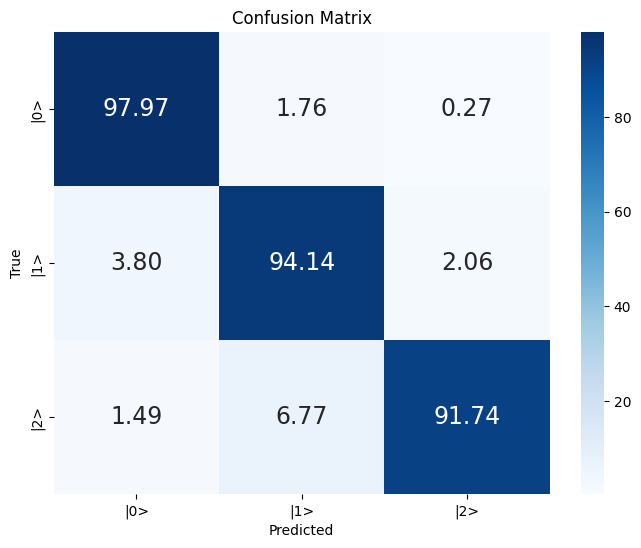

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred=model.predict(x_test)
argmax_indices = np.argmax(y_pred, axis=1)
num_classes = y_pred.shape[1]
y_pred = np.zeros_like(y_pred)
y_pred[np.arange(len(argmax_indices)), argmax_indices] = 1

# Combine the true and predicted labels into one matrix for confusion matrix computation
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Normalize the confusion matrix to show percentages
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with larger font size for percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=['|0>', '|1>', '|2>'], yticklabels=['|0>', '|1>', '|2>'], annot_kws={"size": 17})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
